In [50]:
data_path = "../data/"
img_path = data_path + "images/"

In [51]:
import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from skimage import io, transform
from torchvision import transforms, utils
import torch.optim as optim
import time
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import warnings
warnings.filterwarnings("ignore")

import model_v3dot3 as modelClass

In [52]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/3"
embed = hub.Module(module_url)
tf.logging.set_verbosity(tf.logging.ERROR)

In [53]:
data_path = "../data/"
whole_data = pickle.load(open("whole_data", "rb"))

In [54]:
test_imgs = np.loadtxt(data_path + "referit_test_imlist.txt").astype("int")
test_ids = np.isin(whole_data["img"].values.astype("int"), test_imgs)
tst_ids = list(np.argwhere(test_ids==True))
tst_ids = [item for sublist in tst_ids for item in sublist]
tst_ids = np.array(tst_ids)

In [55]:
test_df = whole_data.iloc[tst_ids]
test_df = whole_data

In [56]:
test_df.head()

,bbox_id,img,loc_act,loc_rel,expr,emb_expr,IoU,GIoU
0,20260_f1,20260,"[0.0, 277.0, 83.0, 336.0]","[0.0, 0.5770833333333333, 0.23055555555555557,...",the sky right hand corner,"[-0.009086175, 0.06696806, -0.07156556, 0.0605...",0.000000,-0.338279
1,20260_f1,20260,"[0.0, 277.0, 83.0, 336.0]","[0.0, 0.5770833333333333, 0.23055555555555557,...",water on right,"[-0.010208251, 0.0080347, -0.045048416, 0.0062...",0.059874,0.043853
2,20260_f1,20260,"[0.0, 277.0, 83.0, 336.0]","[0.0, 0.5770833333333333, 0.23055555555555557,...",middle guy,"[-0.031950668, 0.014514642, 0.006182524, 0.026...",0.000000,-0.632246
3,20260_f2,20260,"[0.0, 203.0, 223.0, 341.0]","[0.0, 0.42291666666666666, 0.6194444444444445,...",the sky right hand corner,"[-0.009086175, 0.06696806, -0.07156556, 0.0605...",0.012796,-0.134117
4,20260_f2,20260,"[0.0, 203.0, 223.0, 341.0]","[0.0, 0.42291666666666666, 0.6194444444444445,...",water on right,"[-0.010208251, 0.0080347, -0.045048416, 0.0062...",0.184423,0.088795


In [57]:
device = 'cuda'

model = modelClass.myModel()
model.to(device)

load = True
load_path = 'models/model_v3.3_full_data_iter66000.pt'

checkpoint = torch.load(load_path)
model.load_state_dict(checkpoint['model_state_dict'])
print()

In [58]:
def get_results(img_id = None, query = '', show_all_boxes = False):
    if img_id is None:
        img_id = str(np.random.choice(test_imgs))
    df = test_df[test_df['img'] == img_id].copy()
    print('Image id: ' + str(img_id))
    print('Generating query embedding...')
    with tf.Session(config=tf.ConfigProto(device_count={'GPU': 0})) as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        query_embedding = session.run(embed([query]))[0]
    print('Query embedding is generated')
    df['expr'] = query
    df['emb_expr'] = [query_embedding] * len(df)
    df = df.drop_duplicates('bbox_id')
    img_dataset = modelClass.LocalizationDataset(data_pickle=df,
                                       data_path=data_path,
                                       transform=transforms.Compose([
                                           # Assuming image size 480x480, bbox size 240x240
                                                   modelClass.Rescale((240,240), (240,240)),
                                                   modelClass.ToTensor()
                                               ]))
    img_loader = torch.utils.data.DataLoader(img_dataset,  batch_size = 32, shuffle = False, num_workers=2)

    tick = time.time()
    cos_sims = []
    i = 0
    print('Forward passing the model...')
    with torch.set_grad_enabled(False):
        for sample in img_loader:
            image, bbox_image, loc_rel, embedding, IoU = modelClass.get_torch_data(sample)
            outputs = model(image,bbox_image,loc_rel,embedding)
            img_seg, word_seg = torch.split(outputs, 512, dim=1)
            cos_sim = torch.sum(img_seg * word_seg, dim=1).cpu().numpy()
            cos_sims += list(cos_sim)
    print('Cosine similarity of the embedding are calculated.')
    df['cos_sim'] = cos_sims
    if not show_all_boxes:
        df = df.sort_values('cos_sim')
        df_len = df.shape[0]
        df = pd.concat([df.iloc[:3,:],df.iloc[-3:]])
    #print(df.shape)
    #print(df)
    image = Image.open(img_path + img_id + ".jpg").convert("RGBA")
    tmp = Image.new('RGBA', image.size, (255,255,255,0))
    draw = ImageDraw.Draw(tmp)
    for idx, row in df.iterrows(): 
        x1, y1, x2, y2 = row["loc_act"]
        #font = ImageFont.truetype('verdana', size=10)
        font = ImageFont.load_default()
        score = row["cos_sim"]
        color = (int(255*(1-score)), int(255*score), 0, 150)
        text = "{0:.3f}".format(score)
        w, h = font.getsize(text)

        # Draw the label box
        draw.rectangle((x1,y1,x1+w+8,y1+h+8), fill=color)    

        # Draw the outline box
        draw.rectangle((x1,y1,x2,y2), outline="red")

        # Write text
        #draw.text((x1+5, y1+3), "0.68", fill="black", font=font)
        draw.text((x1+5, y1+3), text, fill=(255,255,255,255), font=font)

    image = Image.alpha_composite(image, tmp)
    return image

Image id: 31470
Generating query embedding...
Query embedding is generated
Forward passing the model...
Cosine similarity of the embedding are calculated.


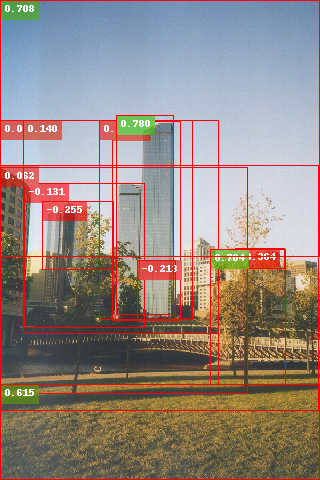

In [59]:
get_results(img_id = '31470', query='building in the center', show_all_boxes=True)

In [ ]:
get_results(img_id = '31470', query='building in the center', show_all_boxes=True)

Image id: 27384
Generating query embedding...
Query embedding is generated
Forward passing the model...
Cosine similarity of the embedding are calculated.


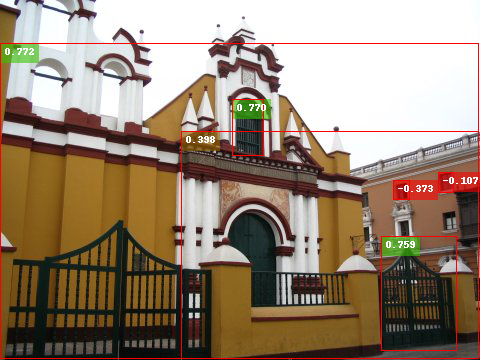

In [62]:
get_results(img_id = '27384', query='gate', show_all_boxes=False)

In [ ]:
get_results(img_id = '27384', query='gate', show_all_boxes=False)